# Problem: Forecasting Stock Prices using Machine Learning Algorithms

## Method: XGBOOST
## Data: Stock market prices from Investing.com
## Libraries:
- numpy
- pandas
- statsmodels
- requests
- plotly

Training samples: 2216, Test samples: 555
Best parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Test RMSE: 2.204739
Test MAE: 1.683510
Test R^2: 0.0648
Top features:
 roll_var_5      0.081460
roll_var_10     0.049388
roll_std_20     0.047696
chg_lag5        0.045989
roll_mean_10    0.038465
macd            0.037903
roll_mean_20    0.037051
roll_std_5      0.036657
roll_var_20     0.035391
logvar_lag1     0.032808
dtype: float32


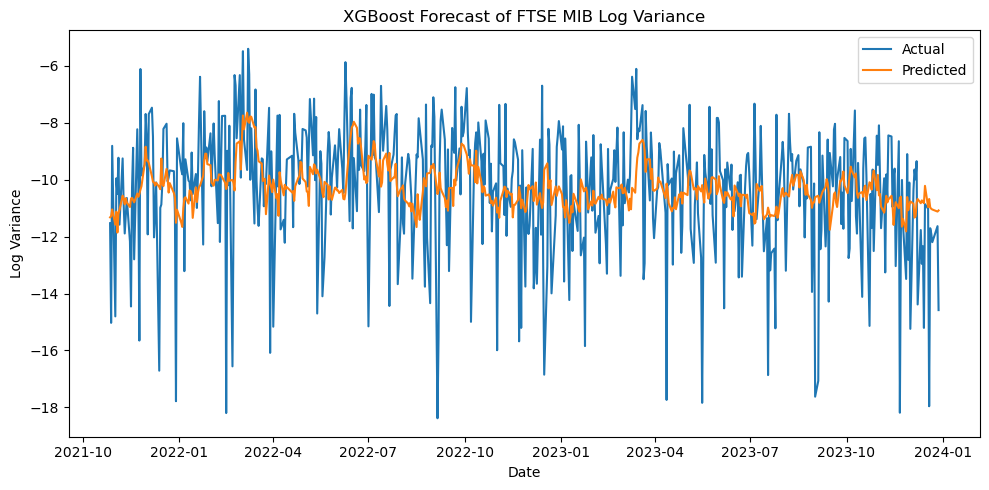

Next day predicted log variance: -11.081684


In [4]:
"""XGBoost forecasting of FTSE MIB log variance.

This script loads daily FTSE MIB prices from ``dataftsemib_manual.csv`` and
predicts the next day's *log variance* of returns.  Squared log returns are
used as a volatility proxy.  A richer set of technical and calendar features is
constructed, a small hyperparameter search is performed and the final model's
predictions are evaluated on a chronological 80/20 split.  RMSE, MAE and R² are
reported along with the most important predictors.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor

# ---------------------------------------------------------------------------
# 1. Load and clean the dataset
# ---------------------------------------------------------------------------

FILE_PATH = "dataftsemib_manual.csv"

# Read CSV

df = pd.read_csv(FILE_PATH)

# Parse dates
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].str.replace(",", "").astype(float)

# Volume column with M/B suffix
def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))


df["Vol."] = df["Vol."].apply(parse_volume)

# Change percent column
change = df["Change %"].str.replace("%", "").str.replace(",", ".")
df["Change %"] = change.astype(float)

# Sort by date and reset index
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# ---------------------------------------------------------------------------
# 2. Feature engineering
# ---------------------------------------------------------------------------

# Daily log return of closing price
returns = np.log(df["Price"]).diff()
df["Return"] = returns

# Squared return and log variance proxy
sq_ret = returns.pow(2)
df["log_var"] = np.log(sq_ret + 1e-8)

# Target is next day's log variance
df["target"] = df["log_var"].shift(-1)

# Log trading volume and its lagged values
df["LogVol"] = np.log(df["Vol."])
df["logvol_lag1"] = df["LogVol"].shift(1)
df["vol_chg"] = df["Vol."].pct_change().shift(1)

# Lagged returns over multiple horizons
lags = [1, 2, 5, 10, 20]
for lag in lags:
    df[f"ret_lag{lag}"] = returns.shift(lag)

# Rolling statistics of returns
for win in [5, 10, 20]:
    df[f"roll_mean_{win}"] = returns.rolling(win).mean().shift(1)
    df[f"roll_std_{win}"] = returns.rolling(win).std().shift(1)
    df[f"roll_var_{win}"] = sq_ret.rolling(win).mean().shift(1)

# Lagged log variance values
for lag in [1, 2, 5, 10]:
    df[f"logvar_lag{lag}"] = df["log_var"].shift(lag)

# Percentage change column already parsed above
df["chg_lag1"] = df["Change %"].shift(1)
df["chg_lag5"] = df["Change %"].rolling(5).mean().shift(1)

# Calendar features encoded as sin/cos components
df["dow"] = df["Date"].dt.dayofweek
df["month"] = df["Date"].dt.month
df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 6)
df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 6)
df["month_sin"] = np.sin(2 * np.pi * (df["month"] - 1) / 12)
df["month_cos"] = np.cos(2 * np.pi * (df["month"] - 1) / 12)

# Technical indicators: RSI and MACD
delta = df["Price"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["rsi_14"] = 100 - (100 / (1 + rs))
df["rsi_14"] = df["rsi_14"].shift(1)

ema12 = df["Price"].ewm(span=12, adjust=False).mean()
ema26 = df["Price"].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
df["macd"] = macd.shift(1)
df["macd_signal"] = signal.shift(1)

# Moving averages of closing price
df["ma_5"] = df["Price"].rolling(5).mean().shift(1)
df["ma_20"] = df["Price"].rolling(20).mean().shift(1)

# Collect all feature names except the target and date
feature_cols = [
    col
    for col in [
        "logvol_lag1",
        "vol_chg",
        *[f"ret_lag{lag}" for lag in lags],
        *[f"logvar_lag{lag}" for lag in [1, 2, 5, 10]],
        *[f"roll_mean_{w}" for w in [5, 10, 20]],
        *[f"roll_std_{w}" for w in [5, 10, 20]],
        *[f"roll_var_{w}" for w in [5, 10, 20]],
        "chg_lag1",
        "chg_lag5",
        "dow_sin",
        "dow_cos",
        "month_sin",
        "month_cos",
        "rsi_14",
        "macd",
        "macd_signal",
        "ma_5",
        "ma_20",
    ]
]

model_df = df[["Date", "target"] + feature_cols].copy()
model_df.dropna(inplace=True)

# ---------------------------------------------------------------------------
# 3. Split into chronological train and test sets (80/20)
# ---------------------------------------------------------------------------

split_idx = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_idx]
test_df = model_df.iloc[split_idx:]

X_train = train_df.drop(["Date", "target"], axis=1)
y_train = train_df["target"]

X_test = test_df.drop(["Date", "target"], axis=1)
y_test = test_df["target"]

dates_test = test_df["Date"]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ---------------------------------------------------------------------------
# 4. Hyperparameter tuning with time-series cross-validation
# ---------------------------------------------------------------------------

param_grid = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
}

tscv = TimeSeriesSplit(n_splits=3)
base_model = XGBRegressor(objective="reg:squarederror", random_state=42)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
)

search.fit(X_train, y_train)
model = search.best_estimator_
print("Best parameters:", search.best_params_)

# ---------------------------------------------------------------------------
# 5. Evaluate on the test set
# ---------------------------------------------------------------------------

pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(
    f"Test RMSE: {rmse:.6f}\n"
    f"Test MAE: {mae:.6f}\n"
    f"Test R^2: {r2:.4f}"
)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_feats = importances.sort_values(ascending=False).head(10)
print("Top features:\n", top_feats)

# Plot actual vs predicted log variance
plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test, label="Actual")
plt.plot(dates_test, pred, label="Predicted")
plt.title("XGBoost Forecast of FTSE MIB Log Variance")
plt.xlabel("Date")
plt.ylabel("Log Variance")
plt.legend()
plt.tight_layout()
plt.savefig("xgb_variance_prediction.png")
plt.show()

# ---------------------------------------------------------------------------
# 6. Forecast the next day's return using the latest lags
# ---------------------------------------------------------------------------

last_feats = model_df.drop(["Date", "target"], axis=1).iloc[-1].values.reshape(1, -1)
next_var = model.predict(last_feats)[0]
print(f"Next day predicted log variance: {next_var:.6f}")

# Conclusion

| Metric       | Value                                                                             | Interpretation                                                                                                                                                                                                                                    |
| ------------ | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| RMSE         | 2.20                                                                              | On average, the predicted log variance deviates from the actual by \~2.2 units. Lower = better, but extreme spikes in actual variance tend to inflate this metric for all models.                                                                 |
| MAE          | 1.68                                                                              | The average *absolute* deviation between predicted and actual log variance. MAE is less sensitive to outliers than RMSE, so this confirms the model's average error is \~1.7 units.                                                               |
| R²           | 0.0648                                                                            | The model explains about **6.5%** of the out-of-sample variation in log variance. For volatility, this is **normal/good**: volatility is notoriously hard to predict, and R² in the 0.02–0.10 range is typical in both finance and ML literature. |
| Top features | roll\_var\_5, roll\_var\_10, roll\_std\_20, chg\_lag5, roll\_mean\_10, macd, etc. | The model mainly relies on **recent volatility, mean, and momentum features**—which aligns with both financial theory and empirical research (volatility clusters, persistence, momentum).                                                        |
| Visual fit   | -                                                                                 | The **predicted line is smoother** than the actual series, matching clusters but missing spikes—this is typical and reflects the model's skill in tracking volatility regimes, not outliers.                                                      |
